In [1]:
import os
os.environ["PYSPARK_SUBMIT_ARGS"]='--packages com.databricks:spark-csv_2.10:1.3.0 pyspark-shell'
execfile(os.path.join(os.environ["SPARK_HOME"], 'python/pyspark/shell.py'))

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 2.0.2
      /_/

Using Python version 2.7.6 (default, Mar 22 2014 22:59:56)
SparkSession available as 'spark'.


In [2]:
#import os
#import sys


#os.environ['SPARK_HOME'] = '/usr/lib/spark'
#sys.path.insert(0, '/usr/lib/spark/python/lib/py4j-0.9-src.zip')
#sys.path.insert(0, '/usr/lib/spark/python/')
#sys.path.insert(0, '/usr/local/lib64/python2.7/site-packages')
#sys.path.insert(0,'/usr/local/lib/python2.7/site-packages')

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
import seaborn as sns

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [5]:
import numpy as np
import pandas as pd
import time
import json

from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, MapType
import pyspark.sql.functions as F

In [6]:
from operator import add
from pyspark.sql.types import ArrayType, MapType

# Summary

### Train
 * 10'531'564 records
 * 227'211 users
 *  24'021 items
 * N ratings per user
   * min 1, max 4'627
   * avg ~46, median ~14
   * 90% <= 115
 * N ratings per item
   * min 1, max 36'548
   * avg ~389, median ~17
   * 90% <= 831
   
### Test
 * 10'531'564 records
 * 227'143 users
 *  24'041 items
 * N ratings per user to predict
   * min 1, max 4627
   * avg ~46
 * N ratings per item to predict
   * min 1, max 36'138 
   * avg ~438
   
### Train vs Test intersection
 *   1'849 users from test is missed from train
 *   2'758 items from test is missed from train
 *  84'633 users from test has less than 10 ratings in train
 * 127'706 users from test has less than 20 ratings in train
 
### Tags
 * 470'509 tag records
 * there are several tag per user-item pair
 * 39'218 unique tags
 * 8'676 users has tagged at least one item
 * 19'553 items has been tagged by at least one user
 * on average 20 movies with tags per user 
 * (1 <= n_rated_movies_with_tags_per_user <= 10695)
 * on averahe movie has been tagged by 9 users
 * (1 <= n_users_who_tagged_item_per_item <= 582 )
 
### Movie description
 * contains title and genres of the movies
 * 27'303 records
 * 20 genres 
 * Dramma most frequent one - occurs in 24% of movies
 * 1342 unique combination of genres

# Exploratory data analysis

## Train

In [11]:
train = spark.read.load("/recsys/lab12data/train.csv", 
                        format="com.databricks.spark.csv", 
                        delimiter=",", 
                        header=True,
                        schema=StructType([StructField("userId",  IntegerType()),
                                           StructField("movieId", IntegerType()),
                                           StructField("rating",  FloatType()),
                                           StructField("timestamp",  IntegerType())]))

In [13]:
train.count()

10531564

In [14]:
train.registerTempTable("train")

In [15]:
users = spark.sql("select userId,count(*) as n_ratings from train group by userId")

In [16]:
users.count()

227211

In [18]:
users.select("n_ratings").describe().show()

+-------+-----------------+
|summary|        n_ratings|
+-------+-----------------+
|  count|           227211|
|   mean| 46.3514706594311|
| stddev|95.56203586713552|
|    min|                1|
|    max|             4627|
+-------+-----------------+



In [19]:
n_rate_per_user_sample = users.select("n_ratings").sample(False, 0.10).toPandas()

median 14.0
avg 46.124475648
90% percentile 115.0


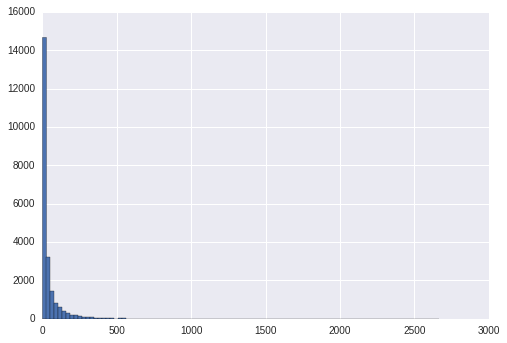

In [26]:
n_rate_per_user_sample.n_ratings.hist(bins=100)
print 'median', np.median(n_rate_per_user_sample.n_ratings)
print 'avg', np.mean(n_rate_per_user_sample.n_ratings)
print '90% percentile', np.percentile(n_rate_per_user_sample.n_ratings, 90)

In [27]:
items = spark.sql("select movieId,count(*) as n_ratings from train group by movieId")

In [28]:
items.select("n_ratings").describe().show()

+-------+------------------+
|summary|         n_ratings|
+-------+------------------+
|  count|             24021|
|   mean|438.43153906998043|
| stddev|1720.3730285115657|
|    min|                 1|
|    max|             36548|
+-------+------------------+



In [29]:
n_rate_per_item_sample = items.select("n_ratings").sample(False, 0.10).toPandas()

median 17.0
avg 388.492765957
90% percentile 831.4


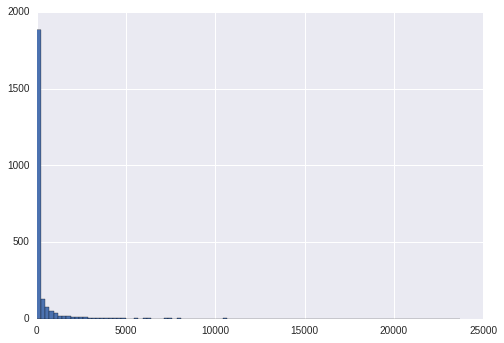

In [30]:
n_rate_per_item_sample.n_ratings.hist(bins=100)
print 'median', np.median(n_rate_per_item_sample.n_ratings)
print 'avg', np.mean(n_rate_per_item_sample.n_ratings)
print '90% percentile', np.percentile(n_rate_per_item_sample.n_ratings, 90)

## Test

In [36]:
test = spark.read.load("/recsys/lab12data/test.csv", 
                        format="com.databricks.spark.csv", 
                        delimiter=",", 
                        header=True,
                        schema=StructType([StructField("userId",  IntegerType()),
                                           StructField("movieId", IntegerType())]))

In [38]:
test.show(3)

+------+-------+
|userId|movieId|
+------+-------+
|     1|   1414|
|     1|   2346|
|     1|   5278|
+------+-------+
only showing top 3 rows



In [39]:
test.count()

10531564

In [40]:
test.registerTempTable("test")
test_users = spark.sql("select userId, count(*) as n_ratings from test group by userId")
test_items = spark.sql("select movieId,count(*) as n_ratings from test group by movieId")

In [41]:
test_users.select("n_ratings").describe().show()

+-------+-----------------+
|summary|        n_ratings|
+-------+-----------------+
|  count|           227143|
|   mean|46.36534694003337|
| stddev| 95.5750452574018|
|    min|                1|
|    max|             4627|
+-------+-----------------+



In [42]:
test_items.select("n_ratings").describe().show()

+-------+------------------+
|summary|         n_ratings|
+-------+------------------+
|  count|             24041|
|   mean|438.06680254565117|
| stddev|1719.7150193274172|
|    min|                 1|
|    max|             36138|
+-------+------------------+



In [43]:
test_users.filter("n_ratings == 4627").show()

+------+---------+
|userId|n_ratings|
+------+---------+
|143495|     4627|
+------+---------+



In [44]:
users.filter("n_ratings == 4627").show()

+------+---------+
|userId|n_ratings|
+------+---------+
|143495|     4627|
+------+---------+



In [45]:
test_users.registerTempTable("test_users")
users.registerTempTable("train_users")


In [47]:
spark.sql("""select count(*) as n_users_missed_from_train
             from test_users tst
             left join train_users trn on tst.userId = trn.userId
             where trn.userId is null
             """).show()

+-------------------------+
|n_users_missed_from_train|
+-------------------------+
|                     1849|
+-------------------------+



In [48]:
spark.sql("""select count(*) as n_users_has_lt10ratings_in_train
             from test_users tst
             join train_users trn on tst.userId = trn.userId
             where trn.n_ratings < 10
             """).show()

+--------------------------------+
|n_users_has_lt10ratings_in_train|
+--------------------------------+
|                           84633|
+--------------------------------+



In [49]:
spark.sql("""select count(*) as n_users_has_lt20ratings_in_train
             from test_users tst
             join train_users trn on tst.userId = trn.userId
             where trn.n_ratings < 20
             """).show()

+--------------------------------+
|n_users_has_lt20ratings_in_train|
+--------------------------------+
|                          127706|
+--------------------------------+



In [50]:
test_items.registerTempTable("test_items")
items.registerTempTable("train_items")

In [51]:
spark.sql("""select count(*) as n_items_missed_from_train
             from test_items tst
             left join train_items trn on tst.movieId = trn.movieId
             where trn.movieId is null
             """).show()

+-------------------------+
|n_items_missed_from_train|
+-------------------------+
|                     2758|
+-------------------------+



## Tags

In [96]:
tags = spark.read.load("/recsys/lab12data/tags.csv", 
                        format="com.databricks.spark.csv", 
                        delimiter=",", 
                        header=True,
                        schema=StructType([StructField("userId",  IntegerType()),
                                           StructField("movieId", IntegerType()),
                                           StructField("tag",  StringType())]))

In [56]:
tags.show(3)

+------+-------+---------------+
|userId|movieId|            tag|
+------+-------+---------------+
|    28|    274|  Kevin Costner|
|    28|    274|based on a book|
|    28|    274|  based on book|
+------+-------+---------------+
only showing top 3 rows



In [63]:
tags.count()

470509

In [64]:
tags.select("tag").distinct().count()

39218

In [57]:
tags.registerTempTable("tags")

In [61]:
ui_tag = spark.sql("""select userId,count(*) as n_rated_movies_with_tags
                       from(
                          select distinct userId,movieId from tags) x
                       group by  userId  
                          """)

In [62]:
ui_tag.select("n_rated_movies_with_tags").describe().show()

+-------+------------------------+
|summary|n_rated_movies_with_tags|
+-------+------------------------+
|  count|                    8676|
|   mean|      20.538842784693408|
| stddev|      169.37967919586308|
|    min|                       1|
|    max|                   10695|
+-------+------------------------+



In [66]:
iu_tag = spark.sql("""select movieId,count(*) as n_users_who_tagged_item
                       from(
                          select distinct userId,movieId from tags) x
                       group by  movieId  
                          """)

In [67]:
iu_tag.select("n_users_who_tagged_item").describe().show()

+-------+-----------------------+
|summary|n_users_who_tagged_item|
+-------+-----------------------+
|  count|                  19553|
|   mean|      9.113435278473892|
| stddev|     21.577203620199036|
|    min|                      1|
|    max|                    582|
+-------+-----------------------+



## Movie description

In [70]:
movies = spark.read.load("/recsys/lab12data/movies.csv", 
                        format="com.databricks.spark.csv", 
                        delimiter=",", 
                        header=True)

In [73]:
movies.show(3)

+-------+--------------------+---------------+
|movieId|               title|         genres|
+-------+--------------------+---------------+
|      1|Poltergeist II: T...|Horror|Thriller|
|      2|V: The Final Batt...|  Action|Sci-Fi|
|      3|Wool Cap, The (2004)|          Drama|
+-------+--------------------+---------------+
only showing top 3 rows



In [74]:
movies.select("movieId").distinct().count()

27303

In [75]:
movies.select("genres").distinct().count()

1342

In [88]:
m1=movies.select("movieId","title",F.split("genres",'\\|').alias("genre_list"))\
         .select("movieId",F.explode("genre_list").alias("genre"))

In [90]:
m1.show(2)

+-------+--------+
|movieId|   genre|
+-------+--------+
|      1|  Horror|
|      1|Thriller|
+-------+--------+
only showing top 2 rows



In [91]:
genres = m1.groupBy("genre").count().toPandas()

In [95]:
genres['ratio'] = genres['count'] * 1. / genres['count'].sum()
genres.sort_values(by="count", ascending=False)

,genre,count,ratio
4,Drama,13355,0.245298
16,Comedy,8378,0.153883
2,Thriller,4183,0.076831
1,Romance,4131,0.075876
18,Action,3522,0.064690
0,Crime,2941,0.054019
14,Horror,2612,0.047976
6,Documentary,2471,0.045386
3,Adventure,2330,0.042796
19,Sci-Fi,1743,0.032015


In [94]:
genres.shape

(20, 2)

## Links

In [97]:
links = spark.read.load("/recsys/lab12data/links.csv", 
                        format="com.databricks.spark.csv", 
                        delimiter=",", 
                        header=True)

In [100]:
links.show(5,truncate=False)

+-------+-------+------+
|movieId|imdbId |tmdbId|
+-------+-------+------+
|1      |0091778|11133 |
|2      |0086823|140161|
|3      |0377972|81700 |
|4      |0028436|110733|
|5      |0086465|1621  |
+-------+-------+------+
only showing top 5 rows



In [104]:
links.select("movieId").distinct().count()

27303

In [105]:
# Sanity check of avg rating

In [106]:
x=train.filter("movieId == 1").toPandas()

In [107]:
x.rating.mean()

2.4009186351706036

In [108]:
x.shape

(762, 4)

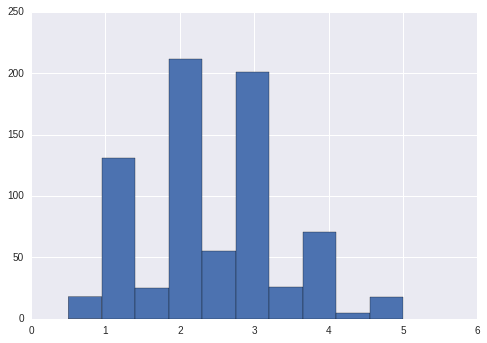

In [109]:
x.rating.hist()